# Entraînement du Neural Network pour Smart Chess sur Google Colab

Ce notebook permet d'entraîner le réseau de neurones pour l'évaluation d'échecs en utilisant les ressources GPU de Google Colab.

**Chemin du projet sur Drive:** `MyDrive/smart_chess_drive/smart-chess`

## Instructions
1. Aller dans **Runtime > Change runtime type > GPU** (T4 ou mieux)
2. Exécuter les cellules dans l'ordre
3. Les modèles seront sauvegardés automatiquement sur votre Drive

## 1. Vérification GPU

In [1]:
# Vérifier la disponibilité du GPU
!nvidia-smi

Thu Nov 13 08:54:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Montage Google Drive

In [2]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Configuration du chemin du projet

In [3]:
# Définir le chemin vers le projet sur votre Drive
import os
import sys

PROJECT_PATH = '/content/drive/MyDrive/smart_chess_drive/smart-chess'
os.chdir(PROJECT_PATH)
sys.path.insert(0, PROJECT_PATH)

print(f"Répertoire de travail: {os.getcwd()}")
print(f"\nContenu du répertoire:")
for item in sorted(os.listdir('.')):
    print(f"  - {item}")

Répertoire de travail: /content/drive/MyDrive/smart_chess_drive/smart-chess

Contenu du répertoire:
  - README.md
  - ai
  - docs
  - prototypes


## 4. Installation des dépendances

In [4]:
# Installer les packages nécessaires
!pip install -q torch torchvision torchaudio
!pip install -q numpy matplotlib tqdm

print("✓ Installation terminée")

✓ Installation terminée


## 5. Vérification de l'environnement PyTorch

In [5]:
import torch
import numpy as np

print("=" * 60)
print("CONFIGURATION SYSTÈME")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"\nCUDA disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Nom du GPU: {torch.cuda.get_device_name(0)}")
    props = torch.cuda.get_device_properties(0)
    print(f"Mémoire GPU totale: {props.total_memory / 1e9:.2f} GB")
    print(f"Compute Capability: {props.major}.{props.minor}")
else:
    print("⚠️ ATTENTION: GPU non disponible, l'entraînement sera très lent!")
    print("   Allez dans Runtime > Change runtime type > GPU")

print("=" * 60)

CONFIGURATION SYSTÈME
PyTorch version: 2.8.0+cu126
NumPy version: 2.0.2

CUDA disponible: True
CUDA version: 12.6
Nom du GPU: Tesla T4
Mémoire GPU totale: 15.83 GB
Compute Capability: 7.5


## 6. Import des modules du projet

In [ ]:
# Importer les modules nécessaires depuis le projet (robuste à l'emplacement du repo sur Drive)
import os
import sys
import importlib

# Assurez-vous que PROJECT_PATH est défini et ajoutez également le dossier `ai` au PYTHONPATH
PROJECT_PATH = '/content/drive/MyDrive/smart_chess_drive/smart-chess'
AI_SUBDIR = os.path.join(PROJECT_PATH, 'ai')

# Vérifier les chemins alternatifs (si l'utilisateur a copié le repo dans /content)
ALT_PATH = '/content/smart-chess'

# Choisir un chemin existant
if not os.path.isdir(PROJECT_PATH) and os.path.isdir(ALT_PATH):
    PROJECT_PATH = ALT_PATH

if not os.path.isdir(PROJECT_PATH):
    raise FileNotFoundError(f"Répertoire projet introuvable: {PROJECT_PATH}. Montez Drive et vérifiez le chemin.")

# Ajouter au sys.path si nécessaire
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)
if AI_SUBDIR not in sys.path and os.path.isdir(AI_SUBDIR):
    sys.path.insert(0, AI_SUBDIR)

# Se placer dans le répertoire projet
os.chdir(PROJECT_PATH)

print('Répertoire de travail:', os.getcwd())
print('\nQuelques fichiers à la racine du projet:')
print(sorted(os.listdir(PROJECT_PATH))[:50])
print('\nContenu du dossier ai/:')
print(sorted(os.listdir(AI_SUBDIR))[:100])

# Diagnostic d'import direct pour le module Chess
try:
    import Chess
    print('\n✅ Import direct `Chess` OK (module trouvé via sys.path)')
except Exception as e:
    print('\n❌ Import direct `Chess` a échoué:', e)
    print('Vérifiez que `ai/Chess.py` existe et que le dossier ai/ est dans sys.path')

# Maintenant importer le module d'entraînement (trainer) - UPDATED to torch_train
try:
    import ai.NN.torch_train as trainer
    import ai.NN.torch_nn_evaluator as torch_eval
    from ai.Chess_v2 import Chess
    print('\n✓ Modules importés avec succès!')
except Exception as e:
    print('\n❌ Erreur d\'import lors de l\'import du trainer:', e)
    raise


Répertoire de travail: /content/drive/MyDrive/smart_chess_drive/smart-chess

Quelques fichiers à la racine du projet:
['README.md', 'ai', 'docs', 'prototypes']

Contenu du dossier ai/:
['AI_reduction', 'Chess.py', 'ChessInteractif - v7.py', 'ChessInteractifv10.py', 'ChessInteractifv2.py', 'Chess_v2.py', 'NN', 'Null_move_AI', 'Old_AI', 'Player.py', 'Profile', 'Tests.py', '__init__.py', '__pycache__', 'alphabeta.py', 'alphabeta_engine.py', 'alphabeta_engine_v2.py', 'analyze_reduction_overhead.py', 'base_engine.py', 'check_dataset_stats.py', 'check_gpu.py', 'check_performance.py', 'checkpoints', 'chess_model_checkpoint.pt', 'debug_conversion.py', 'engine.py', 'engine_match.py', 'evaluator.py', 'example_move_reduction.py', 'fast_evaluator.py', 'gaviota.py', 'journal-experiments.md', 'optimized_chess.py', 'pgn.py', 'polyglot.py', 'profile_report_1760344602.txt', 'py.typed', 'svg.py', 'syzygy.py', 'test_depth_6_performance.py', 'test_depth_6_quick.py', 'test_depth_effectiveness.py', 'test_en

## 7. Configuration de l'entraînement

In [ ]:
# Paramètres d'entraînement (NNUE architecture)
CONFIG = {
    # Génération de données
    'num_games': 10000,          # Nombre de parties à générer pour l'entraînement

    # Hyperparamètres NNUE
    'batch_size': 256,           # Taille du batch (augmenter si GPU puissant)
    'epochs': 50,                # Nombre d'époques d'entraînement
    'learning_rate': 0.001,      # Taux d'apprentissage

    # Architecture NNUE (768 → 4096 → 256 → 32 → 1)
    'hidden1': 4096,
    'hidden2': 256,
    'hidden3': 32,
    'dropout': 0.0,              # NNUE ne use pas de dropout

    # Configuration système
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 2,            # Workers pour le DataLoader

    # Sauvegarde
    'checkpoint_path': 'ai/chess_model_checkpoint.pt',
    'save_interval': 5,          # Sauvegarder tous les N époques
}

print("=" * 60)
print("CONFIGURATION DE L'ENTRAÎNEMENT (NNUE)")
print("=" * 60)
for key, value in CONFIG.items():
    print(f"{key:20s}: {value}")
print("=" * 60)

if CONFIG['device'] == 'cpu':
    print("\n⚠️ ATTENTION: Entraînement sur CPU détecté!")
    print("   Réduisez num_games et epochs pour un test rapide.")


CONFIGURATION DE L'ENTRAÎNEMENT
num_games           : 10000
batch_size          : 256
epochs              : 50
learning_rate       : 0.001
device              : cuda
num_workers         : 2
checkpoint_path     : ai/chess_model_checkpoint.pt
save_interval       : 5


## 8. Génération des données d'entraînement

Cette étape génère des parties d'échecs aléatoires et calcule les évaluations de position.
**Attention:** Cela peut prendre 15-30 minutes selon le nombre de parties.

In [9]:
# Localiser le dataset sur Google Drive et préparer le dossier de checkpoints
import os
from glob import glob

# Chemin attendu du dossier contenant le dataset (donné par l'user)
# Updated based on user's feedback that the file is directly in smart_chess_drive
DATASET_DIR = '/content/drive/MyDrive/smart_chess_drive/'

# Chercher un fichier .csv dans DATASET_DIR
DATASET_CSV = None
if os.path.exists(DATASET_DIR):
    csvs = glob(os.path.join(DATASET_DIR, '*.csv'))
    if len(csvs) > 0:
        # Assuming there's only one relevant CSV in that dir, pick the first one
        DATASET_CSV = csvs[0]
        print(f'✅ Dataset CSV trouvé: {DATASET_CSV}')
    else:
        print(f'❌ Aucun fichier .csv trouvé dans {DATASET_DIR}. Placez votre fichier chessData.csv dans ce dossier.')
else:
    print(f'❌ Dossier dataset introuvable: {DATASET_DIR}. Vérifiez le chemin sur votre Drive.')

# Créer un dossier de checkpoints dans le repo sur Drive (persistant)
CKPT_DIR = '/content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)
print('Dossier de checkpoints (créé si manquant):', CKPT_DIR)

# Exposer variables utiles
print('\nVariables exposées:')
print(' DATASET_CSV =', DATASET_CSV)
print(' CKPT_DIR =', CKPT_DIR)

✅ Dataset CSV trouvé: /content/drive/MyDrive/smart_chess_drive/chessData.csv
Dossier de checkpoints (créé si manquant): /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints

Variables exposées:
 DATASET_CSV = /content/drive/MyDrive/smart_chess_drive/chessData.csv
 CKPT_DIR = /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints


In [ ]:
from tqdm import tqdm
import time

print("Chargement du dataset (depuis chessData)...")

# Préférer la variable DATASET_CSV (définie après le montage Drive) sinon utiliser la valeur par défaut du module trainer
dataset_path = globals().get('DATASET_CSV')

if dataset_path is None:
    raise FileNotFoundError('Aucun chemin de dataset défini. Montez Drive et placez le fichier CSV dans MyDrive/smart_chess_drive/chessData')

start_time = time.time()

# Utiliser la fonction de chargement du script d'entraînement pour assurer le même prétraitement
fens, evaluations = trainer.load_data(dataset_path)

# Variables attendues plus bas dans le notebook
X_train = fens
y_train = evaluations

elapsed_time = time.time() - start_time

print("\n" + "=" * 60)
print("DONNÉES CHARGÉES")
print("=" * 60)
print(f"Nombre total de positions: {len(X_train):,}")
print(f"Temps écoulé: {elapsed_time:.1f}s ({elapsed_time/60:.1f} min)")
print("=" * 60)

# Statistiques sur les évaluations
print(f"\nStatistiques sur les évaluations:")
print(f"  Min: {y_train.min():.4f}")
print(f"  Max: {y_train.max():.4f}")
print(f"  Moyenne: {y_train.mean():.4f}")
print(f"  Écart-type: {y_train.std():.4f}")


Chargement du dataset (depuis chessData)...
📂 Chargement du dataset depuis /content/drive/MyDrive/smart_chess_drive/chessData.csv...
🧹 Nettoyage : 190154 lignes corrompues supprimées.
✅ 12,767,881 positions valides chargées.

DONNÉES CHARGÉES
Nombre total de positions: 12,767,881
Temps écoulé: 19.6s (0.3 min)

Statistiques sur les évaluations:
  Min: -15.3120
  Max: 15.3190
  Moyenne: 0.0455
  Écart-type: 0.8139


In [ ]:
import inspect
import ai.NN.torch_train as trainer

try:
    # Get the source code of the load_data function
    source_code = inspect.getsource(trainer.load_data)
    print("Source code of trainer.load_data:")
    print("=" * 60)
    print(source_code)
    print("=" * 60)
except TypeError:
    print("Could not get source code for trainer.load_data. It might not be a function defined in the file.")
except FileNotFoundError:
    print("Could not find the torch_train.py file.")
except Exception as e:
    print(f"An error occurred while trying to get source code: {e}")


Source code of trainer.load_data:
def load_data(filepath: str):
    """Charge le dataset FEN,Evaluation et le nettoie."""
    print(f"📂 Chargement du dataset depuis {filepath}...")
    
    df = pd.read_csv(
        filepath, 
        names=['FEN', 'Evaluation'], 
        skiprows=1,
        comment='#'
    )
    
    initial_count = len(df)
    df.dropna(inplace=True)
    cleaned_count = len(df)
    
    if initial_count > cleaned_count:
        print(f"🧹 Nettoyage : {initial_count - cleaned_count} lignes corrompues supprimées.")
    
    fens = df['FEN'].values
    EVAL_SCALE_FACTOR = 1000.0
    evaluations = (df['Evaluation'].astype(int).values) / EVAL_SCALE_FACTOR
    
    print(f"✅ {len(fens):,} positions valides chargées.")
    return fens, evaluations



In [ ]:
import os

file_path = os.path.join(PROJECT_PATH, 'ai/NN/torch_train.py')

# Read the content of the file
with open(file_path, 'r') as f:
    content = f.read()

# Assuming the load_data function signature is currently load_data(filepath: str):
# We need to verify it accepts a filepath parameter
if 'def load_data(filepath:' in content or 'def load_data(filepath)' in content:
    print(f"✅ La fonction load_data dans {file_path} accepte déjà un paramètre filepath.")
    print("Aucune modification nécessaire.")
else:
    print(f"⚠️ La fonction load_data pourrait nécessiter une modification.")
    print("Vérifiez manuellement si elle accepte un chemin de fichier en paramètre.")


Could not find the function definition 'def load_data():' in /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/NN/train_torch.py. Please inspect the file manually.


## 9. Création du dataset et du dataloader

In [ ]:
from torch.utils.data import DataLoader
from ai.NN.torch_train import ChessDataset

# Créer le dataset
dataset = ChessDataset(X_train, y_train)

# Créer le dataloader
train_loader = DataLoader(
    dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

print("=" * 60)
print("DATALOADER CONFIGURÉ")
print("=" * 60)
print(f"Taille du dataset: {len(dataset):,} échantillons")
print(f"Nombre de batches: {len(train_loader):,}")
print(f"Taille du batch: {CONFIG['batch_size']}")
print(f"Dernière batch: {len(dataset) % CONFIG['batch_size']} échantillons")
print("=" * 60)


DATALOADER CONFIGURÉ
Taille du dataset: 12,767,881 échantillons
Nombre de batches: 49,875
Taille du batch: 256
Dernière batch: 137 échantillons


## 10. Création du modèle

In [ ]:
# Créer le modèle NNUE et le déplacer sur le device approprié
from ai.NN.torch_nn_evaluator import TorchNNEvaluator

model = TorchNNEvaluator(
    hidden1=CONFIG['hidden1'],
    hidden2=CONFIG['hidden2'],
    hidden3=CONFIG['hidden3'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

# Afficher l'architecture
print("=" * 60)
print("ARCHITECTURE DU MODÈLE (NNUE-LIKE)")
print("=" * 60)
print(model)
print("=" * 60)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nNombre total de paramètres: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")
print(f"Device: {CONFIG['device']}")

# Estimer la taille mémoire du modèle
param_size_mb = total_params * 4 / (1024 ** 2)  # 4 bytes par float32
print(f"Taille estimée du modèle: {param_size_mb:.2f} MB")

# Afficher les dimensions des couches
print(f"\nArchitecture détaillée:")
print(f"  Input:  {model.l1.in_features}")
print(f"  Layer 1: {model.l1.out_features} (ReLU)")
print(f"  Layer 2: {model.l2.out_features} (ReLU)")
print(f"  Layer 3: {model.l3.out_features} (ReLU)")
print(f"  Output: {model.l4.out_features} (Linear)")


ARCHITECTURE DU MODÈLE
TorchNNEvaluator(
  (l1): Linear(in_features=768, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (net): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Nombre total de paramètres: 262,913
Paramètres entraînables: 262,913
Device: cuda
Taille estimée du modèle: 1.00 MB


## 11. Entraînement du modèle

Cette étape lance l'entraînement complet. Les checkpoints sont sauvegardés automatiquement sur votre Drive.

In [ ]:
# Configurer et lancer le script d'entraînement `ai.NN.torch_train` en adaptant les chemins pour Colab/Drive
import os
import importlib

if DATASET_CSV is None:
    raise FileNotFoundError(f"Dataset non trouvé dans: {DATASET_DIR}")

# Importer le module d'entraînement (UPDATED: torch_train au lieu de train_torch)
import ai.NN.torch_train as trainer

# Reload the module to pick up recent changes
importlib.reload(trainer)

# Rediriger les chemins dataset et checkpoints vers Drive
trainer.DATASET_PATH = DATASET_CSV
trainer.CHECKPOINT_FILE = os.path.join(CKPT_DIR, os.path.basename(trainer.CHECKPOINT_FILE))
trainer.WEIGHTS_FILE = os.path.join(CKPT_DIR, os.path.basename(trainer.WEIGHTS_FILE))

# Harmonisation des paramètres avec CONFIG
try:
    trainer.BATCH_SIZE = CONFIG['batch_size']
    print(f'✅ Harmonisation: trainer.BATCH_SIZE = {trainer.BATCH_SIZE}')
except Exception as e:
    print('⚠️ Impossible de définir trainer.BATCH_SIZE:', e)

# Appliquer l'architecture NNUE
try:
    trainer.HIDDEN1 = CONFIG['hidden1']
    trainer.HIDDEN2 = CONFIG['hidden2']
    trainer.HIDDEN3 = CONFIG['hidden3']
    trainer.DROPOUT = CONFIG['dropout']
    print(f"✅ Architecture NNUE appliquée: {trainer.HIDDEN1} → {trainer.HIDDEN2} → {trainer.HIDDEN3}")
except Exception as e:
    print('⚠️ Impossible de définir l\'architecture NNUE:', e)

# Optionnellement ajuster MAX_SAMPLES
try:
    trainer.MAX_SAMPLES = 200_000
    print(f"✅ MAX_SAMPLES = {trainer.MAX_SAMPLES}")
except Exception as e:
    print('⚠️ Impossible de définir trainer.MAX_SAMPLES:', e)

# Optionnel: réduire pour test rapide (décommentez si besoin)
# trainer.EPOCHS = 2
# trainer.MAX_SAMPLES = 5000

print('\nConfiguration trainer:')
print(' DATASET_PATH=', trainer.DATASET_PATH)
print(' CHECKPOINT_FILE=', trainer.CHECKPOINT_FILE)
print(' WEIGHTS_FILE=', trainer.WEIGHTS_FILE)
print(' Architecture: 768 →', trainer.HIDDEN1, '→', trainer.HIDDEN2, '→', trainer.HIDDEN3, '→ 1')
print(' EPOCHS=', trainer.EPOCHS)
print(' MAX_SAMPLES=', trainer.MAX_SAMPLES)

# Lancer l'entraînement
trainer.main()


🖥️  Device: cuda
🚀 GPU: Tesla T4
💾 GPU Memory: 15.83 GB
✅ Harmonisation: trainer.BATCH_SIZE = 256
✅ Applied global changes: trainer.HIDDEN_SIZE=512, trainer.MAX_SAMPLES=200000
Configuration trainer:
 DATASET_PATH= /content/drive/MyDrive/smart_chess_drive/chessData.csv
 CHECKPOINT_FILE= /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_model_checkpoint.pt
 WEIGHTS_FILE= /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_nn_weights.npz
 EPOCHS= 10
 MAX_SAMPLES= 200000
📂 Chargement du dataset depuis /content/drive/MyDrive/smart_chess_drive/chessData.csv...
🧹 Nettoyage : 190154 lignes corrompues supprimées.
✅ 12,767,881 positions valides chargées.

📊 Dataset complet: 12,767,881 positions
📥 Chargement du checkpoint PyTorch: /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_model_checkpoint.pt
✅ Checkpoint chargé (step 10), best_rmse=0.4897010028362274
ℹ️ Learning rate enregistré détecté: 0.000050
Saisir le learning rate 

Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]

[GRAD] epoch=1 batch=0 grad_norm=3.883689 max_abs_grad=1.877332 param_norm=2232.449923


Epoch 1/10:   1%|          | 6/782 [00:01<01:48,  7.14it/s, loss=0.8750]


[DEBUG batch 0] targets mean=-0.0469 std=0.7605; preds mean=0.0561 std=0.1002; RMSE=0.7847; corr=-0.1091


Epoch 1/10:  14%|█▍        | 108/782 [00:03<00:14, 46.11it/s, loss=0.8304]

[GRAD] epoch=1 batch=100 grad_norm=4.359676 max_abs_grad=0.407767 param_norm=2232.449781


Epoch 1/10:  26%|██▋       | 206/782 [00:05<00:10, 53.04it/s, loss=0.8230]

[GRAD] epoch=1 batch=200 grad_norm=1.898690 max_abs_grad=0.422694 param_norm=2232.454049


Epoch 1/10:  40%|███▉      | 310/782 [00:06<00:08, 57.87it/s, loss=0.8211]

[GRAD] epoch=1 batch=300 grad_norm=2.281097 max_abs_grad=0.742846 param_norm=2232.456832


Epoch 1/10:  52%|█████▏    | 408/782 [00:08<00:08, 43.21it/s, loss=0.8245]

[GRAD] epoch=1 batch=400 grad_norm=3.400215 max_abs_grad=1.297210 param_norm=2232.460444


Epoch 1/10:  65%|██████▌   | 511/782 [00:10<00:04, 55.59it/s, loss=0.8224]

[GRAD] epoch=1 batch=500 grad_norm=2.076759 max_abs_grad=0.449151 param_norm=2232.464940


Epoch 1/10:  78%|███████▊  | 609/782 [00:12<00:03, 51.38it/s, loss=0.8166]

[GRAD] epoch=1 batch=600 grad_norm=1.969042 max_abs_grad=0.465678 param_norm=2232.469329


Epoch 1/10:  90%|█████████ | 706/782 [00:14<00:01, 48.36it/s, loss=0.8165]

[GRAD] epoch=1 batch=700 grad_norm=2.050190 max_abs_grad=0.806817 param_norm=2232.471371


Epoch 1/10: 100%|██████████| 782/782 [00:16<00:00, 48.70it/s, loss=0.8147]



🔍 Évaluation epoch 1...

EPOCH 1/10 - Évaluation sur 5,000 positions
  RMSE:        0.8174  (baseline: 0.8189)
  MAE:         0.3008
  Amélioration: +0.2% vs baseline
  Corrélation: 0.1794
  Std preds:   0.0103  (cible: 0.8189)
  Mean preds:  0.0173  (cible: 0.0379)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 2] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 2/10:   1%|          | 5/782 [00:00<00:16, 45.83it/s, loss=0.7910]

[GRAD] epoch=2 batch=0 grad_norm=2.244361 max_abs_grad=0.609474 param_norm=2232.473339


Epoch 2/10:  14%|█▍        | 108/782 [00:02<00:12, 54.31it/s, loss=0.8224]

[GRAD] epoch=2 batch=100 grad_norm=2.190279 max_abs_grad=0.251801 param_norm=2232.476260


Epoch 2/10:  27%|██▋       | 211/782 [00:03<00:10, 57.08it/s, loss=0.8051]

[GRAD] epoch=2 batch=200 grad_norm=4.879444 max_abs_grad=1.524861 param_norm=2232.477084


Epoch 2/10:  40%|███▉      | 309/782 [00:05<00:08, 54.87it/s, loss=0.8036]

[GRAD] epoch=2 batch=300 grad_norm=2.003355 max_abs_grad=0.579072 param_norm=2232.478779


Epoch 2/10:  52%|█████▏    | 409/782 [00:07<00:06, 58.46it/s, loss=0.8065]

[GRAD] epoch=2 batch=400 grad_norm=2.597729 max_abs_grad=0.701982 param_norm=2232.481266


Epoch 2/10:  65%|██████▍   | 506/782 [00:09<00:05, 48.78it/s, loss=0.8083]

[GRAD] epoch=2 batch=500 grad_norm=5.734575 max_abs_grad=1.710648 param_norm=2232.483668


Epoch 2/10:  78%|███████▊  | 607/782 [00:11<00:03, 45.99it/s, loss=0.8080]

[GRAD] epoch=2 batch=600 grad_norm=2.782097 max_abs_grad=0.404744 param_norm=2232.486432


Epoch 2/10:  91%|█████████ | 711/782 [00:13<00:01, 56.75it/s, loss=0.8105]

[GRAD] epoch=2 batch=700 grad_norm=6.329337 max_abs_grad=2.494345 param_norm=2232.489085


Epoch 2/10: 100%|██████████| 782/782 [00:14<00:00, 52.42it/s, loss=0.8115]



🔍 Évaluation epoch 2...

EPOCH 2/10 - Évaluation sur 5,000 positions
  RMSE:        0.7977  (baseline: 0.7989)
  MAE:         0.3029
  Amélioration: +0.1% vs baseline
  Corrélation: 0.1166
  Std preds:   0.0110  (cible: 0.7989)
  Mean preds:  0.0476  (cible: 0.0431)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 3] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 3/10:   1%|          | 5/782 [00:00<00:16, 46.16it/s, loss=0.8161]

[GRAD] epoch=3 batch=0 grad_norm=1.641571 max_abs_grad=0.580186 param_norm=2232.491705


Epoch 3/10:  14%|█▎        | 106/782 [00:01<00:11, 57.76it/s, loss=0.8155]

[GRAD] epoch=3 batch=100 grad_norm=1.315633 max_abs_grad=0.527161 param_norm=2232.492927


Epoch 3/10:  27%|██▋       | 209/782 [00:03<00:10, 52.37it/s, loss=0.8063]

[GRAD] epoch=3 batch=200 grad_norm=2.233931 max_abs_grad=0.510228 param_norm=2232.495468


Epoch 3/10:  39%|███▉      | 308/782 [00:05<00:08, 58.39it/s, loss=0.8030]

[GRAD] epoch=3 batch=300 grad_norm=1.884898 max_abs_grad=1.088397 param_norm=2232.497293


Epoch 3/10:  52%|█████▏    | 408/782 [00:07<00:07, 47.34it/s, loss=0.8066]

[GRAD] epoch=3 batch=400 grad_norm=3.248831 max_abs_grad=1.356399 param_norm=2232.500421


Epoch 3/10:  65%|██████▍   | 507/782 [00:09<00:05, 50.14it/s, loss=0.8042]

[GRAD] epoch=3 batch=500 grad_norm=3.484993 max_abs_grad=1.170666 param_norm=2232.502328


Epoch 3/10:  78%|███████▊  | 607/782 [00:11<00:03, 54.32it/s, loss=0.8055]

[GRAD] epoch=3 batch=600 grad_norm=17.571875 max_abs_grad=4.874732 param_norm=2232.504212


Epoch 3/10:  89%|████████▉ | 699/782 [00:13<00:01, 53.01it/s, loss=0.8086]

[GRAD] epoch=3 batch=700 grad_norm=3.254562 max_abs_grad=1.869562 param_norm=2232.506396


Epoch 3/10: 100%|██████████| 782/782 [00:14<00:00, 52.58it/s, loss=0.8082]



🔍 Évaluation epoch 3...

EPOCH 3/10 - Évaluation sur 5,000 positions
  RMSE:        0.8294  (baseline: 0.8304)
  MAE:         0.3136
  Amélioration: +0.1% vs baseline
  Corrélation: 0.1340
  Std preds:   0.0103  (cible: 0.8304)
  Mean preds:  0.0719  (cible: 0.0495)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 4] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 4/10:   1%|          | 5/782 [00:00<00:18, 43.03it/s, loss=0.7866]

[GRAD] epoch=4 batch=0 grad_norm=14.889532 max_abs_grad=6.488861 param_norm=2232.508339


Epoch 4/10:  14%|█▍        | 109/782 [00:02<00:11, 58.13it/s, loss=0.8443]

[GRAD] epoch=4 batch=100 grad_norm=3.358769 max_abs_grad=0.574702 param_norm=2232.510071


Epoch 4/10:  27%|██▋       | 208/782 [00:04<00:12, 47.43it/s, loss=0.8232]

[GRAD] epoch=4 batch=200 grad_norm=5.200048 max_abs_grad=0.725123 param_norm=2232.512675


Epoch 4/10:  40%|███▉      | 309/782 [00:06<00:10, 46.70it/s, loss=0.8240]

[GRAD] epoch=4 batch=300 grad_norm=1.476597 max_abs_grad=0.449057 param_norm=2232.515956


Epoch 4/10:  53%|█████▎    | 412/782 [00:08<00:06, 58.80it/s, loss=0.8143]

[GRAD] epoch=4 batch=400 grad_norm=1.674245 max_abs_grad=0.384426 param_norm=2232.518717


Epoch 4/10:  65%|██████▍   | 505/782 [00:10<00:06, 40.69it/s, loss=0.8100]

[GRAD] epoch=4 batch=500 grad_norm=3.251169 max_abs_grad=0.428811 param_norm=2232.520569


Epoch 4/10:  78%|███████▊  | 607/782 [00:12<00:02, 59.22it/s, loss=0.8137]

[GRAD] epoch=4 batch=600 grad_norm=1.596696 max_abs_grad=0.764232 param_norm=2232.524696


Epoch 4/10:  91%|█████████ | 711/782 [00:13<00:01, 56.24it/s, loss=0.8138]

[GRAD] epoch=4 batch=700 grad_norm=4.660102 max_abs_grad=0.869688 param_norm=2232.527216


Epoch 4/10: 100%|██████████| 782/782 [00:15<00:00, 51.54it/s, loss=0.8122]



🔍 Évaluation epoch 4...

EPOCH 4/10 - Évaluation sur 5,000 positions
  RMSE:        0.7883  (baseline: 0.7893)
  MAE:         0.3033
  Amélioration: +0.1% vs baseline
  Corrélation: 0.0897
  Std preds:   0.0129  (cible: 0.7893)
  Mean preds:  0.0697  (cible: 0.0571)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 5] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 5/10:   1%|          | 5/782 [00:00<00:15, 49.13it/s, loss=0.7232]

[GRAD] epoch=5 batch=0 grad_norm=2.297178 max_abs_grad=0.525420 param_norm=2232.529443


Epoch 5/10:  14%|█▎        | 107/782 [00:02<00:14, 45.30it/s, loss=0.8132]

[GRAD] epoch=5 batch=100 grad_norm=2.692090 max_abs_grad=0.341387 param_norm=2232.530710


Epoch 5/10:  26%|██▋       | 206/782 [00:04<00:10, 56.59it/s, loss=0.8079]

[GRAD] epoch=5 batch=200 grad_norm=1.521599 max_abs_grad=0.728859 param_norm=2232.532799


Epoch 5/10:  40%|███▉      | 310/782 [00:06<00:08, 57.17it/s, loss=0.8123]

[GRAD] epoch=5 batch=300 grad_norm=2.203867 max_abs_grad=0.781315 param_norm=2232.535474


Epoch 5/10:  52%|█████▏    | 408/782 [00:08<00:06, 55.77it/s, loss=0.8070]

[GRAD] epoch=5 batch=400 grad_norm=2.383246 max_abs_grad=0.395894 param_norm=2232.537542


Epoch 5/10:  65%|██████▍   | 507/782 [00:09<00:05, 53.43it/s, loss=0.8059]

[GRAD] epoch=5 batch=500 grad_norm=1.813779 max_abs_grad=0.297263 param_norm=2232.540273


Epoch 5/10:  78%|███████▊  | 611/782 [00:11<00:03, 56.81it/s, loss=0.8061]

[GRAD] epoch=5 batch=600 grad_norm=0.890272 max_abs_grad=0.238522 param_norm=2232.544708


Epoch 5/10:  91%|█████████ | 708/782 [00:13<00:01, 53.96it/s, loss=0.8046]

[GRAD] epoch=5 batch=700 grad_norm=1.997057 max_abs_grad=0.273588 param_norm=2232.548127


Epoch 5/10: 100%|██████████| 782/782 [00:15<00:00, 51.81it/s, loss=0.8034]



🔍 Évaluation epoch 5...

EPOCH 5/10 - Évaluation sur 5,000 positions
  RMSE:        0.8042  (baseline: 0.8054)
  MAE:         0.3043
  Amélioration: +0.2% vs baseline
  Corrélation: 0.1755
  Std preds:   0.0073  (cible: 0.8054)
  Mean preds:  0.0473  (cible: 0.0469)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 6] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 6/10:   1%|          | 5/782 [00:00<00:17, 44.86it/s, loss=0.8721]

[GRAD] epoch=6 batch=0 grad_norm=8.605802 max_abs_grad=5.575995 param_norm=2232.550222


Epoch 6/10:  14%|█▍        | 109/782 [00:02<00:12, 55.80it/s, loss=0.8512]

[GRAD] epoch=6 batch=100 grad_norm=3.296148 max_abs_grad=0.413601 param_norm=2232.553381


Epoch 6/10:  26%|██▋       | 206/782 [00:03<00:10, 53.95it/s, loss=0.8322]

[GRAD] epoch=6 batch=200 grad_norm=1.676006 max_abs_grad=0.372852 param_norm=2232.557651


Epoch 6/10:  40%|███▉      | 309/782 [00:05<00:08, 54.37it/s, loss=0.8182]

[GRAD] epoch=6 batch=300 grad_norm=3.545171 max_abs_grad=1.159436 param_norm=2232.559079


Epoch 6/10:  52%|█████▏    | 408/782 [00:07<00:07, 52.50it/s, loss=0.8187]

[GRAD] epoch=6 batch=400 grad_norm=0.993391 max_abs_grad=0.462444 param_norm=2232.561556


Epoch 6/10:  65%|██████▍   | 505/782 [00:09<00:05, 52.42it/s, loss=0.8181]

[GRAD] epoch=6 batch=500 grad_norm=3.528373 max_abs_grad=0.379514 param_norm=2232.565210


Epoch 6/10:  78%|███████▊  | 608/782 [00:11<00:03, 44.34it/s, loss=0.8156]

[GRAD] epoch=6 batch=600 grad_norm=3.013940 max_abs_grad=0.689278 param_norm=2232.569295


Epoch 6/10:  91%|█████████ | 711/782 [00:13<00:01, 52.25it/s, loss=0.8150]

[GRAD] epoch=6 batch=700 grad_norm=1.423980 max_abs_grad=0.224488 param_norm=2232.572385


Epoch 6/10: 100%|██████████| 782/782 [00:15<00:00, 51.95it/s, loss=0.8140]



🔍 Évaluation epoch 6...

EPOCH 6/10 - Évaluation sur 5,000 positions
  RMSE:        0.8505  (baseline: 0.8512)
  MAE:         0.3180
  Amélioration: +0.1% vs baseline
  Corrélation: 0.1409
  Std preds:   0.0085  (cible: 0.8512)
  Mean preds:  0.0332  (cible: 0.0605)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 7] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 7/10:   1%|          | 6/782 [00:00<00:14, 53.62it/s, loss=0.7783]

[GRAD] epoch=7 batch=0 grad_norm=1.850069 max_abs_grad=0.699533 param_norm=2232.574063


Epoch 7/10:  14%|█▍        | 108/782 [00:02<00:12, 55.32it/s, loss=0.8046]

[GRAD] epoch=7 batch=100 grad_norm=4.110307 max_abs_grad=0.988191 param_norm=2232.577335


Epoch 7/10:  26%|██▋       | 206/782 [00:03<00:11, 51.48it/s, loss=0.8053]

[GRAD] epoch=7 batch=200 grad_norm=1.887258 max_abs_grad=0.688309 param_norm=2232.580986


Epoch 7/10:  40%|███▉      | 311/782 [00:05<00:08, 53.20it/s, loss=0.8143]

[GRAD] epoch=7 batch=300 grad_norm=1.719812 max_abs_grad=0.412045 param_norm=2232.584564


Epoch 7/10:  52%|█████▏    | 407/782 [00:07<00:07, 47.36it/s, loss=0.8188]

[GRAD] epoch=7 batch=400 grad_norm=2.191794 max_abs_grad=0.650022 param_norm=2232.588120


Epoch 7/10:  65%|██████▌   | 510/782 [00:09<00:05, 47.85it/s, loss=0.8166]

[GRAD] epoch=7 batch=500 grad_norm=1.547731 max_abs_grad=0.209765 param_norm=2232.590746


Epoch 7/10:  78%|███████▊  | 609/782 [00:11<00:03, 54.56it/s, loss=0.8184]

[GRAD] epoch=7 batch=600 grad_norm=2.090262 max_abs_grad=0.603115 param_norm=2232.593950


Epoch 7/10:  91%|█████████ | 712/782 [00:13<00:01, 53.58it/s, loss=0.8175]

[GRAD] epoch=7 batch=700 grad_norm=1.823815 max_abs_grad=0.340778 param_norm=2232.597976


Epoch 7/10: 100%|██████████| 782/782 [00:15<00:00, 51.63it/s, loss=0.8183]



🔍 Évaluation epoch 7...

EPOCH 7/10 - Évaluation sur 5,000 positions
  RMSE:        0.8135  (baseline: 0.8143)
  MAE:         0.3009
  Amélioration: +0.1% vs baseline
  Corrélation: 0.1377
  Std preds:   0.0090  (cible: 0.8143)
  Mean preds:  0.0069  (cible: 0.0319)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 8] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 8/10:   1%|          | 6/782 [00:00<00:14, 52.41it/s, loss=0.7166]

[GRAD] epoch=8 batch=0 grad_norm=2.052806 max_abs_grad=0.752447 param_norm=2232.600442


Epoch 8/10:  14%|█▍        | 108/782 [00:02<00:12, 52.46it/s, loss=0.8095]

[GRAD] epoch=8 batch=100 grad_norm=1.781376 max_abs_grad=0.492794 param_norm=2232.602110


Epoch 8/10:  27%|██▋       | 211/782 [00:03<00:10, 55.99it/s, loss=0.8151]

[GRAD] epoch=8 batch=200 grad_norm=3.139232 max_abs_grad=0.334431 param_norm=2232.606204


Epoch 8/10:  40%|███▉      | 309/782 [00:06<00:09, 48.98it/s, loss=0.8223]

[GRAD] epoch=8 batch=300 grad_norm=1.428913 max_abs_grad=0.309194 param_norm=2232.609514


Epoch 8/10:  52%|█████▏    | 406/782 [00:08<00:07, 49.65it/s, loss=0.8236]

[GRAD] epoch=8 batch=400 grad_norm=2.144724 max_abs_grad=0.892972 param_norm=2232.613596


Epoch 8/10:  65%|██████▌   | 510/782 [00:09<00:05, 53.49it/s, loss=0.8208]

[GRAD] epoch=8 batch=500 grad_norm=1.651204 max_abs_grad=0.322458 param_norm=2232.616366


Epoch 8/10:  77%|███████▋  | 606/782 [00:11<00:03, 52.33it/s, loss=0.8186]

[GRAD] epoch=8 batch=600 grad_norm=1.346112 max_abs_grad=0.290910 param_norm=2232.619823


Epoch 8/10:  91%|█████████ | 708/782 [00:13<00:01, 50.08it/s, loss=0.8197]

[GRAD] epoch=8 batch=700 grad_norm=4.655700 max_abs_grad=1.206181 param_norm=2232.623042


Epoch 8/10: 100%|██████████| 782/782 [00:15<00:00, 51.52it/s, loss=0.8177]



🔍 Évaluation epoch 8...

EPOCH 8/10 - Évaluation sur 5,000 positions
  RMSE:        0.6985  (baseline: 0.6995)
  MAE:         0.2783
  Amélioration: +0.1% vs baseline
  Corrélation: 0.1349
  Std preds:   0.0079  (cible: 0.6995)
  Mean preds:  0.0472  (cible: 0.0363)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 9] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 9/10:   1%|          | 5/782 [00:00<00:18, 42.30it/s, loss=0.8816]

[GRAD] epoch=9 batch=0 grad_norm=1.480638 max_abs_grad=0.170524 param_norm=2232.626207


Epoch 9/10:  14%|█▎        | 107/782 [00:02<00:13, 50.57it/s, loss=0.8012]

[GRAD] epoch=9 batch=100 grad_norm=1.281037 max_abs_grad=0.189341 param_norm=2232.628658


Epoch 9/10:  27%|██▋       | 209/782 [00:04<00:13, 43.21it/s, loss=0.8095]

[GRAD] epoch=9 batch=200 grad_norm=1.665386 max_abs_grad=0.405972 param_norm=2232.630740


Epoch 9/10:  39%|███▉      | 307/782 [00:06<00:08, 55.66it/s, loss=0.8076]

[GRAD] epoch=9 batch=300 grad_norm=1.534648 max_abs_grad=0.370911 param_norm=2232.633776


Epoch 9/10:  52%|█████▏    | 407/782 [00:07<00:06, 56.48it/s, loss=0.8043]

[GRAD] epoch=9 batch=400 grad_norm=1.234158 max_abs_grad=0.255626 param_norm=2232.636507


Epoch 9/10:  65%|██████▌   | 509/782 [00:09<00:04, 56.41it/s, loss=0.8079]

[GRAD] epoch=9 batch=500 grad_norm=2.825420 max_abs_grad=1.113012 param_norm=2232.638620


Epoch 9/10:  78%|███████▊  | 609/782 [00:11<00:03, 55.74it/s, loss=0.8096]

[GRAD] epoch=9 batch=600 grad_norm=2.409114 max_abs_grad=0.968143 param_norm=2232.643689


Epoch 9/10:  91%|█████████ | 710/782 [00:13<00:01, 51.96it/s, loss=0.8077]

[GRAD] epoch=9 batch=700 grad_norm=2.893303 max_abs_grad=1.234651 param_norm=2232.648739


Epoch 9/10: 100%|██████████| 782/782 [00:14<00:00, 53.36it/s, loss=0.8097]



🔍 Évaluation epoch 9...

EPOCH 9/10 - Évaluation sur 5,000 positions
  RMSE:        0.7791  (baseline: 0.7804)
  MAE:         0.3034
  Amélioration: +0.2% vs baseline
  Corrélation: 0.1439
  Std preds:   0.0095  (cible: 0.7804)
  Mean preds:  0.0577  (cible: 0.0505)
  ⚠  Faible amélioration - vérifier hyperparamètres


[Epoch 10] 🎲 Échantillonnage: 200,000 positions sur 12,767,881
➡️ Learning rate courant: 0.000050


Epoch 10/10:   1%|          | 4/782 [00:00<00:23, 33.60it/s, loss=0.8481]

[GRAD] epoch=10 batch=0 grad_norm=2.733377 max_abs_grad=1.745903 param_norm=2232.650933


Epoch 10/10:  14%|█▍        | 108/782 [00:02<00:12, 54.77it/s, loss=0.7921]

[GRAD] epoch=10 batch=100 grad_norm=2.417979 max_abs_grad=1.117083 param_norm=2232.652865


Epoch 10/10:  27%|██▋       | 210/782 [00:04<00:10, 53.89it/s, loss=0.8031]

[GRAD] epoch=10 batch=200 grad_norm=1.940448 max_abs_grad=0.228261 param_norm=2232.656209


Epoch 10/10:  39%|███▉      | 307/782 [00:05<00:08, 54.40it/s, loss=0.8027]

[GRAD] epoch=10 batch=300 grad_norm=1.284995 max_abs_grad=0.171064 param_norm=2232.658095


Epoch 10/10:  52%|█████▏    | 409/782 [00:07<00:06, 56.06it/s, loss=0.8096]

[GRAD] epoch=10 batch=400 grad_norm=3.755414 max_abs_grad=1.033444 param_norm=2232.661893


Epoch 10/10:  65%|██████▍   | 505/782 [00:09<00:05, 52.76it/s, loss=0.8105]

[GRAD] epoch=10 batch=500 grad_norm=3.662746 max_abs_grad=0.861382 param_norm=2232.665160


Epoch 10/10:  78%|███████▊  | 608/782 [00:11<00:03, 50.15it/s, loss=0.8121]

[GRAD] epoch=10 batch=600 grad_norm=1.159008 max_abs_grad=0.164601 param_norm=2232.669194


Epoch 10/10:  90%|█████████ | 706/782 [00:13<00:01, 46.82it/s, loss=0.8123]

[GRAD] epoch=10 batch=700 grad_norm=2.097652 max_abs_grad=1.028810 param_norm=2232.673073


Epoch 10/10: 100%|██████████| 782/782 [00:15<00:00, 51.63it/s, loss=0.8122]



🔍 Évaluation epoch 10...

EPOCH 10/10 - Évaluation sur 5,000 positions
  RMSE:        0.8601  (baseline: 0.8599)
  MAE:         0.3232
  Amélioration: -0.0% vs baseline
  Corrélation: 0.1335
  Std preds:   0.0091  (cible: 0.8599)
  Mean preds:  0.0642  (cible: 0.0156)
  ⚠  Faible amélioration - vérifier hyperparamètres


🎉 Entraînement terminé!
📊 Meilleur RMSE: 0.4897

💾 Sauvegarde finale...
Checkpoint PyTorch sauvegardé dans /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_model_checkpoint.pt
Poids sauvegardés (npz) dans /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_nn_weights.npz
✅ Modèle sauvegardé dans /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_model_checkpoint.pt et /content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_nn_weights.npz


## 12. Visualisation des résultats

NameError: name 'history' is not defined

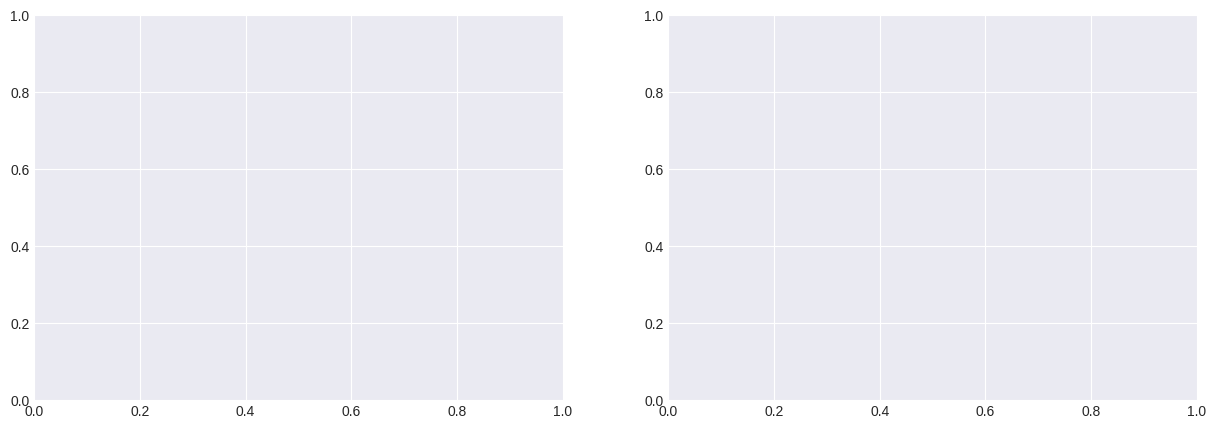

In [15]:
# @title
import matplotlib.pyplot as plt

# Configurer le style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Loss
axes[0].plot(history['loss'], linewidth=2, color='#2E86AB', label='Training Loss')
axes[0].set_xlabel('Époque', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Évolution de la perte pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Afficher les valeurs min/max
min_loss = min(history['loss'])
max_loss = max(history['loss'])
axes[0].axhline(y=min_loss, color='green', linestyle='--', alpha=0.5, label=f'Min: {min_loss:.6f}')
axes[0].legend(fontsize=10)

# Graphique 2: MAE (si disponible)
if 'mae' in history:
    axes[1].plot(history['mae'], linewidth=2, color='#F77F00', label='MAE')
    axes[1].set_xlabel('Époque', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Erreur absolue moyenne', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    min_mae = min(history['mae'])
    axes[1].axhline(y=min_mae, color='green', linestyle='--', alpha=0.5, label=f'Min: {min_mae:.6f}')
    axes[1].legend(fontsize=10)
else:
    axes[1].text(0.5, 0.5, 'MAE non disponible',
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Afficher les statistiques finales
print("\n" + "=" * 60)
print("STATISTIQUES FINALES")
print("=" * 60)
print(f"Perte finale: {history['loss'][-1]:.6f}")
print(f"Perte minimale: {min_loss:.6f} (époque {history['loss'].index(min_loss) + 1})")
if 'mae' in history:
    print(f"MAE final: {history['mae'][-1]:.6f}")
    print(f"MAE minimal: {min_mae:.6f} (époque {history['mae'].index(min_mae) + 1})")
print("=" * 60)

## 13. Sauvegarde du modèle final

In [ ]:
# @title
import datetime

# Timestamp pour identifier cette sauvegarde
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Sauvegarder le modèle complet avec l'historique
final_model_path = f'ai/chess_model_final_{timestamp}.pt'
torch.save({
    'epoch': CONFIG['epochs'],
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'history': history,
    'timestamp': timestamp,
}, final_model_path)

print("=" * 60)
print("SAUVEGARDE DES MODÈLES")
print("=" * 60)
print(f"✓ Modèle final: {final_model_path}")

# Sauvegarder aussi au format .npz pour compatibilité avec l'ancien code
weights_path = 'ai/NN/chess_nn_weights.npz'
weights = {name: param.cpu().detach().numpy() for name, param in model.named_parameters()}
np.savez(weights_path, **weights)
print(f"✓ Poids .npz: {weights_path}")

# Copier aussi le checkpoint dans NN/
import shutil
checkpoint_backup = f'ai/NN/chess_model_checkpoint_{timestamp}.pt'
if os.path.exists(CONFIG['checkpoint_path']):
    shutil.copy(CONFIG['checkpoint_path'], checkpoint_backup)
    print(f"✓ Checkpoint backup: {checkpoint_backup}")

print("=" * 60)
print("\n✅ Tous les fichiers sont sauvegardés sur votre Google Drive!")
print(f"   Chemin: {PROJECT_PATH}")

## 14. Test du modèle sur des positions aléatoires

In [ ]:
# @title
# Passer le modèle en mode évaluation
model.eval()

# Tester sur quelques positions aléatoires
num_tests = 10
test_indices = np.random.choice(len(X_train), num_tests, replace=False)

print("=" * 60)
print(f"TEST SUR {num_tests} POSITIONS ALÉATOIRES")
print("=" * 60)

errors = []

with torch.no_grad():
    for i, idx in enumerate(test_indices, 1):
        x = torch.FloatTensor(X_train[idx:idx+1]).to(CONFIG['device'])
        y_true = y_train[idx]
        y_pred = model(x).cpu().numpy()[0, 0]
        error = abs(y_true - y_pred)
        errors.append(error)

        print(f"\nPosition {i}:")
        print(f"  Évaluation réelle:  {y_true:+8.4f}")
        print(f"  Prédiction modèle:  {y_pred:+8.4f}")
        print(f"  Erreur absolue:     {error:8.4f}")

        # Indicateur visuel de la qualité
        if error < 0.1:
            print(f"  Qualité: ✅ Excellente")
        elif error < 0.3:
            print(f"  Qualité: ✓ Bonne")
        elif error < 0.5:
            print(f"  Qualité: ⚠ Moyenne")
        else:
            print(f"  Qualité: ❌ Faible")

print("\n" + "=" * 60)
print("STATISTIQUES DES TESTS")
print("=" * 60)
print(f"Erreur moyenne: {np.mean(errors):.4f}")
print(f"Erreur médiane: {np.median(errors):.4f}")
print(f"Erreur min:     {np.min(errors):.4f}")
print(f"Erreur max:     {np.max(errors):.4f}")
print(f"Écart-type:     {np.std(errors):.4f}")
print("=" * 60)

## 15. Résumé et fichiers générés

In [ ]:
# @title
print("\n" + "="*60)
print("📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*60)
print(f"\n📍 Projet: {PROJECT_PATH}")
print(f"\n⚙️ Configuration:")
print(f"   • Parties générées: {CONFIG['num_games']:,}")
print(f"   • Positions d'entraînement: {len(X_train):,}")
print(f"   • Époques: {CONFIG['epochs']}")
print(f"   • Batch size: {CONFIG['batch_size']}")
print(f"   • Learning rate: {CONFIG['learning_rate']}")
print(f"   • Device: {CONFIG['device']}")

print(f"\n📈 Résultats:")
print(f"   • Perte finale: {history['loss'][-1]:.6f}")
print(f"   • Perte minimale: {min(history['loss']):.6f}")
if 'mae' in history:
    print(f"   • MAE final: {history['mae'][-1]:.6f}")

print(f"\n💾 Fichiers sauvegardés sur Drive:")
files_to_check = [
    final_model_path,
    CONFIG['checkpoint_path'],
    weights_path,
    'training_history.png'
]

for filepath in files_to_check:
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / (1024 * 1024)  # Convertir en MB
        print(f"   ✓ {filepath} ({size:.2f} MB)")
    else:
        print(f"   ✗ {filepath} (non trouvé)")

print("\n" + "="*60)
print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
print("="*60)
print("\nTous les fichiers sont automatiquement synchronisés avec votre Google Drive.")
print("Vous pouvez fermer ce notebook en toute sécurité.\n")

In [ ]:
# @title
import os

checkpoint_file = '/content/drive/MyDrive/smart_chess_drive/smart-chess/ai/checkpoints/chess_model_checkpoint.pt'

if os.path.exists(checkpoint_file):
    print(f"Removing existing checkpoint file: {checkpoint_file}")
    os.remove(checkpoint_file)
    print("Checkpoint removed.")
else:
    print(f"No checkpoint file found at {checkpoint_file}. No action needed.")

In [ ]:
# Smoke tests automatisés — 3 runs courts pour comparer configurations NNUE
# - Crée une validation fixe, lance 3 expériences courtes (EPOCHS=3, MAX_SAMPLES=100k)
# - Sauvegarde checkpoints séparés et évalue chaque modèle sur la validation fixe

import time
import importlib
import os
import numpy as np
from torch.utils.data import DataLoader

print('Lancement des smoke tests (rapides) avec architecture NNUE.\n')

# Vérifier dataset et données en mémoire
if 'X_train' not in globals() or 'y_train' not in globals():
    print('X_train/y_train non trouvés en mémoire — chargement léger depuis trainer.DATASET_PATH (peut prendre du temps)...')
    fens, evaluations = trainer.load_data(trainer.DATASET_PATH)
    X_train = fens
    y_train = evaluations

# Créer validation fixe (seed deterministe)
val_size = min(5000, len(X_train))
rs = np.random.RandomState(42)
val_idx = rs.choice(len(X_train), size=val_size, replace=False)
val_fens = X_train[val_idx]
val_targets = y_train[val_idx]
print(f'Validation fixe : {val_size} positions (seed=42)')

# Sauvegarder originaux pour restauration
orig_keys = ['HIDDEN1','HIDDEN2','HIDDEN3','DROPOUT','LEARNING_RATE','WEIGHT_DECAY','BATCH_SIZE','EPOCHS','MAX_SAMPLES','CHECKPOINT_FILE','WEIGHTS_FILE','EVAL_MAX_SAMPLES']
orig = {k: getattr(trainer, k) for k in orig_keys if hasattr(trainer, k)}

# Expériences à tester (NNUE architecture variations)
experiments = [
    {'name': 'baseline', 'HIDDEN1': 4096, 'HIDDEN2': 256, 'HIDDEN3': 32, 'DROPOUT': 0.0, 'LEARNING_RATE': 0.001},
    {'name': 'bigger', 'HIDDEN1': 8192, 'HIDDEN2': 512, 'HIDDEN3': 64, 'DROPOUT': 0.0, 'LEARNING_RATE': 5e-4},
    {'name': 'smaller_lr', 'HIDDEN1': 4096, 'HIDDEN2': 256, 'HIDDEN3': 32, 'DROPOUT': 0.0, 'LEARNING_RATE': 1e-4},
]

results = []

for exp in experiments:
    print('\n' + '='*80)
    print(f"Exp: {exp['name']}")
    print('='*80)

    # Set quick test params
    trainer.EPOCHS = 3
    trainer.MAX_SAMPLES = 100_000
    trainer.EVAL_MAX_SAMPLES = 2000

    # Apply experiment overrides
    trainer.HIDDEN1 = exp['HIDDEN1']
    trainer.HIDDEN2 = exp['HIDDEN2']
    trainer.HIDDEN3 = exp['HIDDEN3']
    trainer.DROPOUT = exp['DROPOUT']
    trainer.LEARNING_RATE = exp['LEARNING_RATE']

    # Use separate checkpoint/weights files to avoid overwriting
    ckpt_path = os.path.join(CKPT_DIR, f"smoke_{exp['name']}.pt")
    weights_path = os.path.join(CKPT_DIR, f"smoke_{exp['name']}.npz")
    trainer.CHECKPOINT_FILE = ckpt_path
    trainer.WEIGHTS_FILE = weights_path

    print('Parameters:')
    print(f" Architecture: 768 → {trainer.HIDDEN1} → {trainer.HIDDEN2} → {trainer.HIDDEN3} → 1")
    print(f" DROPOUT={trainer.DROPOUT}, LR={trainer.LEARNING_RATE}")
    print(f" EPOCHS={trainer.EPOCHS}, MAX_SAMPLES={trainer.MAX_SAMPLES}")
    print(f" CHECKPOINT -> {trainer.CHECKPOINT_FILE}")

    # Run training (blocking)
    t0 = time.time()
    try:
        trainer.main()
    except Exception as e:
        print('Erreur pendant trainer.main():', e)
    t1 = time.time()
    print(f"Run time: {t1-t0:.1f}s")

    # Load model from checkpoint
    try:
        model = trainer.TorchNNEvaluator(hidden1=trainer.HIDDEN1, hidden2=trainer.HIDDEN2, hidden3=trainer.HIDDEN3, dropout=trainer.DROPOUT)
        optimizer = trainer.optim.AdamW(model.parameters(), lr=trainer.LEARNING_RATE, weight_decay=trainer.WEIGHT_DECAY)
        model, optim_state, step = trainer.torch_load_checkpoint(trainer.CHECKPOINT_FILE, model, optimizer, device=trainer.DEVICE)

        # Evaluation on fixed val set
        eval_dataset = trainer.ChessDataset(val_fens, val_targets)
        eval_loader = DataLoader(eval_dataset, batch_size=max(1, trainer.BATCH_SIZE//2), shuffle=False)
        rmse, mae, corr, preds, targets = trainer.evaluate_model(model, eval_loader, trainer.DEVICE)
        print(f"Eval results — RMSE: {rmse:.4f}, MAE: {mae:.4f}, Corr: {corr:.4f}")
        results.append({'exp': exp['name'], 'rmse': rmse, 'mae': mae, 'corr': corr})
    except FileNotFoundError:
        print('Checkpoint not found, skipping evaluation for this experiment.')
        results.append({'exp': exp['name'], 'rmse': None, 'mae': None, 'corr': None})
    except Exception as e:
        print('Erreur lors de l\'évaluation:', e)
        results.append({'exp': exp['name'], 'rmse': None, 'mae': None, 'corr': None})

# Restore original trainer settings
for k, v in orig.items():
    setattr(trainer, k, v)

print('\n' + '='*80)
print('Résumé des smoke tests:')
for r in results:
    print(r)
print('='*80)


In [ ]:
# Smoke-extended paramétrable — runs répétés et mode rapide (NNUE)
# Usage:
# - régler FAST_MODE=True pour itérations ultra-rapides (EPOCHS=1, MAX_SAMPLES=20k)
# - régler REPS pour répéter chaque expérience sur plusieurs seeds

import time
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

print('\n=== Smoke-extended démarré (NNUE) ===')

# Paramètres utilisateur
FAST_MODE = False
EPOCHS_EXT = 5
MAX_SAMPLES_EXT = 200_000
REPS = 1
BASE_SEED = 42

if FAST_MODE:
    EPOCHS_EXT = 1
    MAX_SAMPLES_EXT = 20_000

print(f"FAST_MODE={FAST_MODE}, EPOCHS={EPOCHS_EXT}, MAX_SAMPLES={MAX_SAMPLES_EXT}, REPS={REPS}")

# Vérifier que trainer est chargé
if 'trainer' not in globals():
    raise RuntimeError('Le module trainer (ai.NN.torch_train) doit être importé avant d\'exécuter cette cellule.')

# Charger données si nécessaire
if 'X_train' not in globals() or 'y_train' not in globals():
    print('X_train/y_train non présents en mémoire — chargement via trainer.load_data(...)')
    fens, evaluations = trainer.load_data(trainer.DATASET_PATH)
    X_train = fens
    y_train = evaluations

# Validation fixe
val_size = min(5000, len(X_train))
rs = np.random.RandomState(42)
val_idx = rs.choice(len(X_train), size=val_size, replace=False)
val_fens = X_train[val_idx]
val_targets = y_train[val_idx]
print(f'Validation fixe : {val_size} positions (seed=42)')

# Conserver paramètres originaux
orig_keys = ['HIDDEN1','HIDDEN2','HIDDEN3','DROPOUT','LEARNING_RATE','WEIGHT_DECAY','BATCH_SIZE','EPOCHS','MAX_SAMPLES','CHECKPOINT_FILE','WEIGHTS_FILE','EVAL_MAX_SAMPLES']
orig = {k: getattr(trainer, k) for k in orig_keys if hasattr(trainer, k)}

# Expériences NNUE
experiments = [
    {'name': 'baseline', 'HIDDEN1': 4096, 'HIDDEN2': 256, 'HIDDEN3': 32, 'DROPOUT': 0.0, 'LEARNING_RATE': 0.001},
    {'name': 'bigger', 'HIDDEN1': 8192, 'HIDDEN2': 512, 'HIDDEN3': 64, 'DROPOUT': 0.0, 'LEARNING_RATE': 5e-4},
    {'name': 'smaller_lr', 'HIDDEN1': 4096, 'HIDDEN2': 256, 'HIDDEN3': 32, 'DROPOUT': 0.0, 'LEARNING_RATE': 1e-4},
]

results = []

for exp in experiments:
    for rep in range(REPS):
        seed = BASE_SEED + rep
        run_name = f"{exp['name']}_r{rep+1}_s{seed}"
        print('\n' + '='*80)
        print(f"Run: {run_name}")
        print('='*80)

        trainer.EPOCHS = EPOCHS_EXT
        trainer.MAX_SAMPLES = MAX_SAMPLES_EXT
        trainer.EVAL_MAX_SAMPLES = min(2000, MAX_SAMPLES_EXT//50)

        trainer.HIDDEN1 = exp['HIDDEN1']
        trainer.HIDDEN2 = exp['HIDDEN2']
        trainer.HIDDEN3 = exp['HIDDEN3']
        trainer.DROPOUT = exp['DROPOUT']
        trainer.LEARNING_RATE = exp['LEARNING_RATE']

        ckpt_path = os.path.join(CKPT_DIR, f"smoke_ext_{run_name}.pt")
        weights_path = os.path.join(CKPT_DIR, f"smoke_ext_{run_name}.npz")
        trainer.CHECKPOINT_FILE = ckpt_path
        trainer.WEIGHTS_FILE = weights_path

        print('Params:', f"Arch: 768→{trainer.HIDDEN1}→{trainer.HIDDEN2}→{trainer.HIDDEN3}→1, dropout={trainer.DROPOUT}, lr={trainer.LEARNING_RATE}")
        print('Run params:', f"EPOCHS={trainer.EPOCHS}, MAX_SAMPLES={trainer.MAX_SAMPLES}")

        try:
            import torch
            np.random.seed(seed)
            torch.manual_seed(seed)
            if trainer.DEVICE and 'cuda' in str(trainer.DEVICE):
                torch.cuda.manual_seed_all(seed)
        except Exception:
            pass

        t0 = time.time()
        try:
            trainer.main()
        except Exception as e:
            print('Erreur pendant trainer.main():', e)
        t1 = time.time()
        print(f'Run time: {t1-t0:.1f}s')

        try:
            model = trainer.TorchNNEvaluator(hidden1=trainer.HIDDEN1, hidden2=trainer.HIDDEN2, hidden3=trainer.HIDDEN3, dropout=trainer.DROPOUT)
            optimizer = trainer.optim.AdamW(model.parameters(), lr=trainer.LEARNING_RATE, weight_decay=getattr(trainer,'WEIGHT_DECAY',1e-4))
            model, opt_state, step = trainer.torch_load_checkpoint(trainer.CHECKPOINT_FILE, model, optimizer, device=trainer.DEVICE)

            eval_dataset = trainer.ChessDataset(val_fens, val_targets)
            eval_loader = DataLoader(eval_dataset, batch_size=max(1, trainer.BATCH_SIZE//2), shuffle=False)
            rmse, mae, corr, preds, targets = trainer.evaluate_model(model, eval_loader, trainer.DEVICE)
            print(f"Eval — RMSE: {rmse:.4f}, MAE: {mae:.4f}, Corr: {corr:.4f}")
            results.append({'run': run_name, 'exp': exp['name'], 'seed': seed, 'rmse': rmse, 'mae': mae, 'corr': corr, 'ckpt': trainer.CHECKPOINT_FILE})
        except FileNotFoundError:
            print('Checkpoint introuvable.')
            results.append({'run': run_name, 'exp': exp['name'], 'seed': seed, 'rmse': None, 'mae': None, 'corr': None, 'ckpt': trainer.CHECKPOINT_FILE})
        except Exception as e:
            print('Erreur évaluation:', e)
            results.append({'run': run_name, 'exp': exp['name'], 'seed': seed, 'rmse': None, 'mae': None, 'corr': None, 'ckpt': trainer.CHECKPOINT_FILE})

for k, v in orig.items():
    setattr(trainer, k, v)

print('\n=== Résumé smoke-extended ===')
df = pd.DataFrame(results)
print(df)

summary_path = os.path.join(CKPT_DIR, 'smoke_extended_summary.csv')
df.to_csv(summary_path, index=False)
print('Résumé sauvegardé dans', summary_path)
